# Analysis of synapse-mitochondria spatial relationships
#### Adam Tyson | adam.tyson@icr.ac.uk | 2018-09-24

#### Analyses all mitochondria together (i.e. its n x m where n=num synapses, and m=search intervals, not n x m x p where p=number of synapses).


### Import modules

In [1]:
from skimage import io
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy import spatial
import math
import skimage.morphology as morphology
import skimage.measure as measure
from skimage.color import label2rgb
import skimage.filters as filters
import ipywidgets as ipyw
from collections import Counter
import pandas as pd
from IPython.display import display
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [18, 10]


### Define data

In [2]:
path = "F:\mito-synapse-EM\Mitochondria Volume relationship analysis"
mito_ctrl_files = glob.glob('MitoCTRL*.tif')
mito_dtg_files = glob.glob('MitoDTG*.tif')

print(mito_ctrl_files)
print(mito_dtg_files)

[]
[]


In [3]:
# define paths to data 
# todo: move into loop
path = "F:\mito-synapse-EM\Mitochondria Volume relationship analysis"
synapse_file = "SynapseCTRL1a.tif"
mito_file = "MitoCTRL1a.tif"
os.chdir(path)

### Variables

In [4]:
# voxel sizes in nm - anisotropy corrected for
voxel_xy = 3
voxel_z = 70
p_norm = 2 # euclidian
max_dist = 500 # maximum distance to measure in nm
dist_interval = 50 # how many steps in nm
visualise = False
results_filename = "synapse_results.csv"

### 3D viewer class

In [5]:
if visualise:
    # Class from github.com/mohakpatel/ImageSliceViewer3D
    # to view 3D data slice by slice
    class ImageSliceViewer3D:
        """ 
        ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
        ipython notebooks. 

        User can interactively change the slice plane selection for the image and 
        the slice plane being viewed. 

        Arguments:
        Volume = 3D input image
        figsize = default(8,8), to set the size of the figure
        cmap = default('plasma'), string for the matplotlib colormap. You can find 
        more matplotlib colormaps on the following link:
        https://matplotlib.org/users/colormaps.html

        """

        def __init__(self, volume, figsize=(8,8), cmap='plasma'):
            self.volume = volume
            self.figsize = figsize
            self.cmap = "Greys_r"
            self.v = [np.min(volume), np.max(volume)]

            # Call to select slice plane
            ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
                options=['x-y','y-z', 'z-x'], value='x-y', 
                description='Slice plane selection:', disabled=False,
                style={'description_width': 'initial'}))

        def view_selection(self, view):
            # Transpose the volume to orient according to the slice plane selection
            orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
            self.vol = np.transpose(self.volume, orient[view])
            maxZ = self.vol.shape[2] - 1

            # Call to view a slice within the selected slice plane
            ipyw.interact(self.plot_slice, 
                z=ipyw.IntSlider(min=0, max=maxZ, step=1, continuous_update=False, 
                description='Image Slice:'))

        def plot_slice(self, z):
            # Plot slice for the given plane and slice
            self.fig = plt.figure(figsize=self.figsize)
            plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap), 
                vmin=self.v[0], vmax=self.v[1])

### Load and visualise raw data

In [6]:
# load images and take first colour of RGB
synapse_im = io.imread(synapse_file, plugin='pil')[:,:,:,0]
mito_im = io.imread(mito_file, plugin='pil')[:,:,:,0]
print("Image size: ", synapse_im.shape)

if visualise:
    ImageSliceViewer3D(synapse_im)
    ImageSliceViewer3D(mito_im)

Image size:  (25, 1782, 2798)


### Find synapse centres and make kdtree
##### Doesn't really need to use kdtree (especially this implementation)

In [7]:
# prep images - single colours are (0, 179)
synapse_labels = np.zeros(synapse_im.shape)
synapse_labels[synapse_im!=np.max(synapse_im)] = 1

synapse_labels = measure.label(synapse_labels)
synapse_regions = measure.regionprops(synapse_labels)
print("Found", len(synapse_regions), "synapses")

Found 27 synapses


In [8]:
synapse_z = []
synapse_y = []
synapse_x = []

# get all synapse centroids
for region in synapse_regions:
    z, y, x = region.centroid
    synapse_z.append(z)
    synapse_y.append(y)
    synapse_x.append(x)

synapse_z = np.asarray(synapse_z) * voxel_z
synapse_y = np.asarray(synapse_y) * voxel_xy       
synapse_x = np.asarray(synapse_x) * voxel_xy        

synapse_coords = np.vstack((synapse_z, synapse_y, synapse_x))
synapse_coords = np.transpose(synapse_coords)

# generate tree
synapse_tree = spatial.KDTree(synapse_coords)

### Make mitochdondria kdtree

In [9]:
# prep mitochondria coordinates
mito_z, mito_y, mito_x = np.nonzero(mito_im > np.min(mito_im))
mito_z = mito_z * voxel_z
mito_y = mito_y * voxel_xy
mito_x = mito_x * voxel_xy

mito_coords = np.vstack((mito_z, mito_y, mito_x))
mito_coords = np.transpose(mito_coords)

# generate tree
mito_tree = spatial.KDTree(mito_coords, leafsize=mito_coords.shape[0]+1)

### Query the synapse tree against the mitochondria one

In [10]:
synapses=np.arange(0, len(synapse_coords)) # same for all distances
distances = np.arange(0, max_dist, dist_interval) # all distances to test

# intialise
synapses_array = []
volumes_array = []
distances_array = []

# for each distance, query how many mitochondria voxels are within it, for each synapse
for distance in distances:
    print("Calculating volume at distance:", distance)
    tree_query = synapse_tree.query_ball_tree(mito_tree, distance, p=p_norm)
    volumes = [len(synapse) for synapse in tree_query]
    distances=np.ones((len(synapse_coords)))*distance
    
    # put them all in the same array
    synapses_array = np.append(synapses_array, synapses)
    volumes_array = np.append(volumes_array, volumes)
    distances_array = np.append(distances_array, distances)




Calculating volume at distance: 0
Calculating volume at distance: 50
Calculating volume at distance: 100
Calculating volume at distance: 150
Calculating volume at distance: 200
Calculating volume at distance: 250
Calculating volume at distance: 300
Calculating volume at distance: 350
Calculating volume at distance: 400
Calculating volume at distance: 450


### Plot

In [11]:
# make into pandas dataframe for convenience
df_dict = {'Synapse':synapses_array,'Volume':volumes_array, 'Distance':distances_array}
query_df = pd.DataFrame(df_dict)
query_df.Volume = query_df.Volume*voxel_xy**3


In [12]:
# seaborn setup
matplotlib.rcParams['figure.figsize'] = [18, 10]
sns.set(font_scale=2, rc={"lines.linewidth": 5})
palette = sns.color_palette("mako_r", 2)

Text(0.5,1,'Mitochondria volume at a distance from synapse centroid')

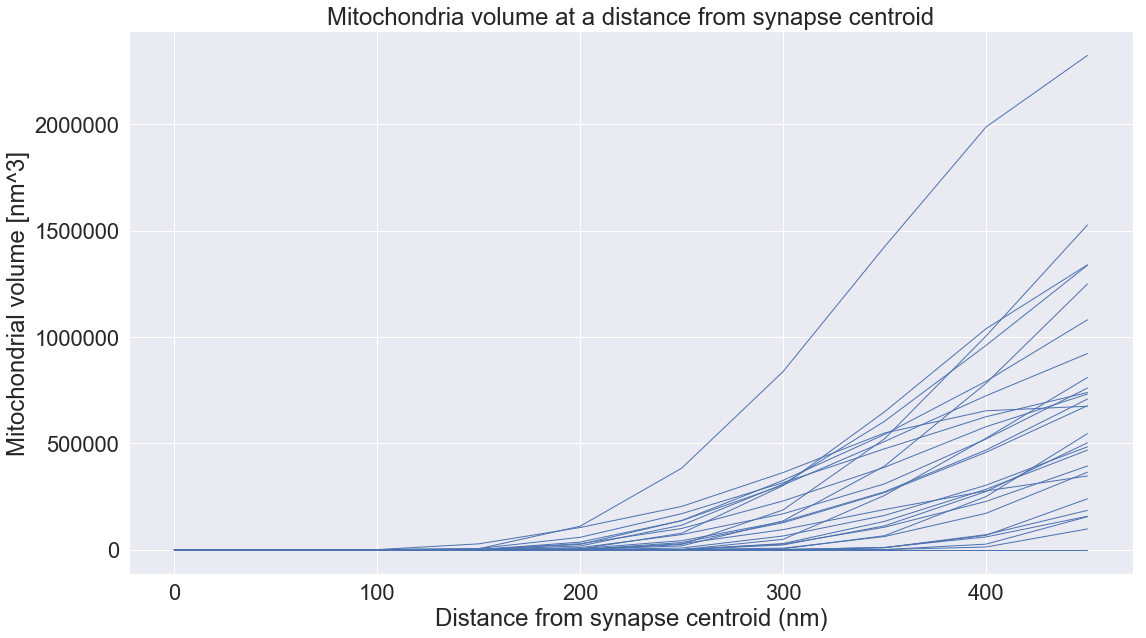

In [13]:
# plot individual synapses
plt.figure()
ax = sns.lineplot(x='Distance', y='Volume', data=query_df,
                               units='Synapse', estimator=None, lw=1, palette=palette )
ax.set(xlabel='Distance from synapse centroid (nm)',
                    ylabel='Mitochondrial volume [nm^3]')
handles, _ = ax.get_legend_handles_labels()
ax.set_title('Mitochondria volume at a distance from synapse centroid')


Text(0.5,1,'Mitochondria volume at a distance from synapse centroid (mean +/- SD)')

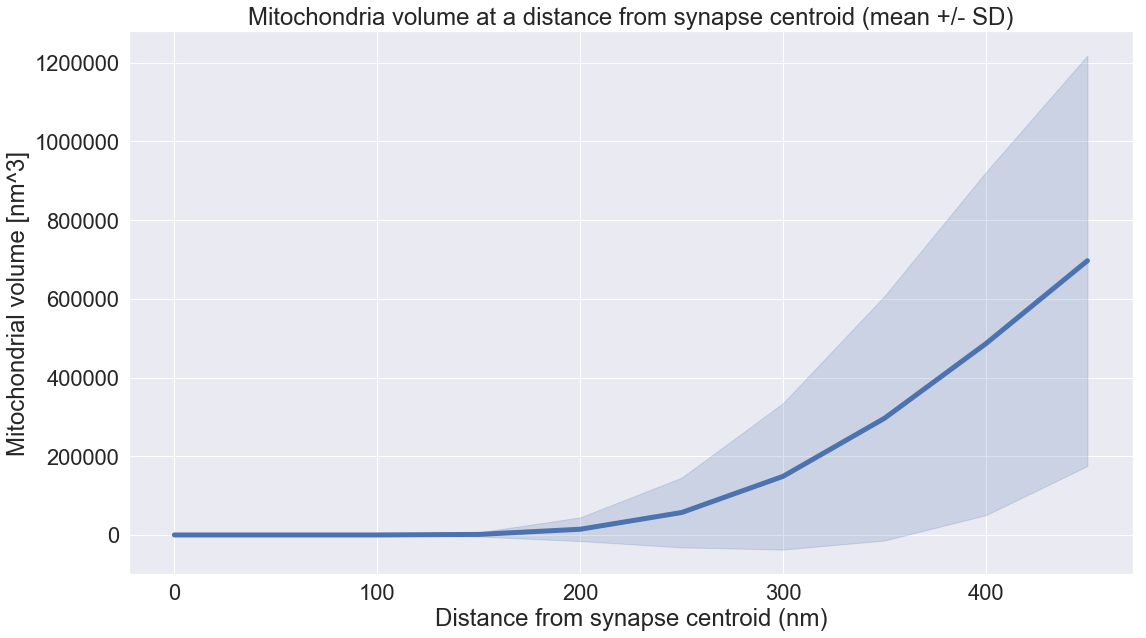

In [14]:
# plot synapses together
plt.figure()
ax = sns.lineplot(x='Distance', y='Volume', data=query_df, ci='sd', palette=palette )
ax.set(xlabel='Distance from synapse centroid (nm)',
                    ylabel='Mitochondrial volume [nm^3]')
handles, _ = ax.get_legend_handles_labels()
ax.set_title('Mitochondria volume at a distance from synapse centroid (mean +/- SD)')


In [15]:
# convert to a "wide" format and save as .xls
query_wide = query_df.pivot(index='Distance', columns='Synapse', values='Volume')
query_wide.to_csv(results_filename)